In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.util import path_expand
from cloudmesh.common.util import writefile
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import math
import platform
import datetime as dt
from pprint import pprint

In [2]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [3]:
def lstm(crypto):
    #"EOS-USD", "DOGE-USD",\n"ETH-USD", and "BTC-USD"
    print(crypto + ' selected')
    StopWatch.start("Overall time")

    # Creating desktop path to save figures to the desktop

    pdfpath = path_expand(f"graphics/{crypto}-prediction-model.pdf")
    pdfpath2 = path_expand(f"graphics/{crypto}-prediction-model-zoomed.pdf")
    pdfpath3 = path_expand(f"graphics/{crypto}-price.pdf")
    pdfpath4 = path_expand(f"graphics/{crypto}-training-loss.pdf")
    pdfpath5 = path_expand(f"graphics/{crypto}-epoch.pdf")
    pdfpath6 = path_expand(f"graphics/{crypto}-prediction-model-zoomed.pdf")

    register_matplotlib_converters()
    ticker = yf.Ticker(crypto)
    data = ticker.history(period="max", interval="1d")
    # print(data)
    # Sort the dataframe according to the date
    data.sort_values('Date', inplace=True, ascending=True)

    # Print the dataframe top
    data.head()

    # Visualization of data. Plotting the price close.
    plt.figure(num=None, figsize=(7, 4), dpi=300, facecolor='w', edgecolor='k')
    days = mdates.drange(data.index.min(), data.index.max() + dt.timedelta(days=1), dt.timedelta(days=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
    if len(days) > len(data['Close']):
        plt.plot(days[:-1], data['Close'])
    elif len(days) < len(data['Close']):
        plt.plot(days, data['Close'].iloc[:-1])
    else:
        plt.plot(days, data['Close'])
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.grid()
    plt.ylabel('Close Price in USD')
    plt.xlabel('Date')
    plt.tight_layout()
    # plt.savefig(fullpath3, dpi=300, facecolor="#FFFFFF")
    plt.savefig(pdfpath3, dpi=300)
    plt.show()

    print(data.index[0])
    firstDate = data.index[0]
    firstDateFormatted = pd.to_datetime(data.index[0], utc=False)
    print(firstDateFormatted)
    date_time_obj = firstDateFormatted.to_pydatetime()
    trueFirstDate = date_time_obj.strftime('%m/%d/%Y')
    print(trueFirstDate)

    print(data.head())

    # Get Close data
    df = data[['Close']].copy()
    # Split data into train and test
    train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

    print(len(train), len(test))

    train_max = train.max()
    train_min = train.min()

    # Normalize the dataframes
    train = (train - train_min) / (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)
    time_steps = 10

    X_train, y_train = create_dataset(train, train.Close, time_steps)
    X_test, y_test = create_dataset(test, test.Close, time_steps)
    StopWatch.start("Training time")

    model = keras.Sequential()
    model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        shuffle=False
    )

    StopWatch.stop("Training time")

    # Plotting the loss
    plt.plot(history.history['loss'], label='train')
    plt.legend()
    plt.ylabel('Model Loss')
    plt.xlabel('Number of Epochs')
    plt.savefig(pdfpath4, dpi=300)
    plt.show()

    StopWatch.start("Prediction time")

    y_pred = model.predict(X_test)

    StopWatch.stop("Prediction time")

    # Rescale the data back to the original scale
    y_test = y_test * (train_max[0] - train_min[0]) + train_min[0]
    y_pred = y_pred * (train_max[0] - train_min[0]) + train_min[0]
    y_train = y_train * (train_max[0] - train_min[0]) + train_min[0]

    # Plotting the results
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', markersize=1,
             label="true")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', markersize=1,
             label="prediction")
    plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', markersize=1, label="history")
    plt.ylabel('Close Price in USD')
    plt.xlabel('Days Since ' + trueFirstDate)
    leg = plt.legend()
    leg_lines = leg.get_lines()
    leg_texts = leg.get_texts()
    plt.setp(leg_lines, linewidth=1)
    plt.setp(leg_texts, fontsize='x-large')
    plt.savefig(pdfpath, dpi=300)
    # doge plt.axis([1350, 1450, 0.14, 0.35])
    # btc plt.axis([2490, 2650, 34000, 73000])
    # eth plt.axis([1370, 1490, 2200, 5800])
    # plt.axis([1440, 1500, 2, 6])
    # plt.title('5 Epochs', fontsize=20)
    plt.savefig(pdfpath5, dpi=300)
    if crypto == "EOS-USD":
        plt.axis([1500, 1560, 1.5, 4.2])
        plt.savefig(pdfpath6, dpi=300)
    elif crypto == "BTC-USD":
        plt.axis([2620, 2750, 31000, 60000])
        plt.savefig(pdfpath6, dpi=300)
    elif crypto == "ETH-USD":
        plt.axis([1500, 1600, 2200, 4000])
        plt.savefig(pdfpath6, dpi=300)
    elif crypto == "DOGE-USD":
        plt.axis([1500, 1600, 0.09, 0.22])
        plt.savefig(pdfpath6, dpi=300)

    plt.show()

    print(y_test.shape)
    print(y_pred.shape)

    ## Outputs error in United States Dollars
    print(f"Root mean squared error: {math.sqrt(mean_squared_error(y_test, y_pred))}")
    #math.sqrt(mean_squared_error(y_test, y_pred))

    ## Create a table of the error against the number of epochs

    StopWatch.stop("Overall time")
    pprint(StopWatch.__dict__)
    core_name = platform.processor().split()[0]
    benchmark_filename = path_expand(f"benchmarks/{core_name}-{crypto}-benchmark.log")
    sysinfo_filename = path_expand(f"benchmarks/{core_name}-{crypto}-systeminfo.log")
    writefile(benchmark_filename, str(StopWatch.__dict__))
    writefile(sysinfo_filename, StopWatch.systeminfo())


EOS-USD selected


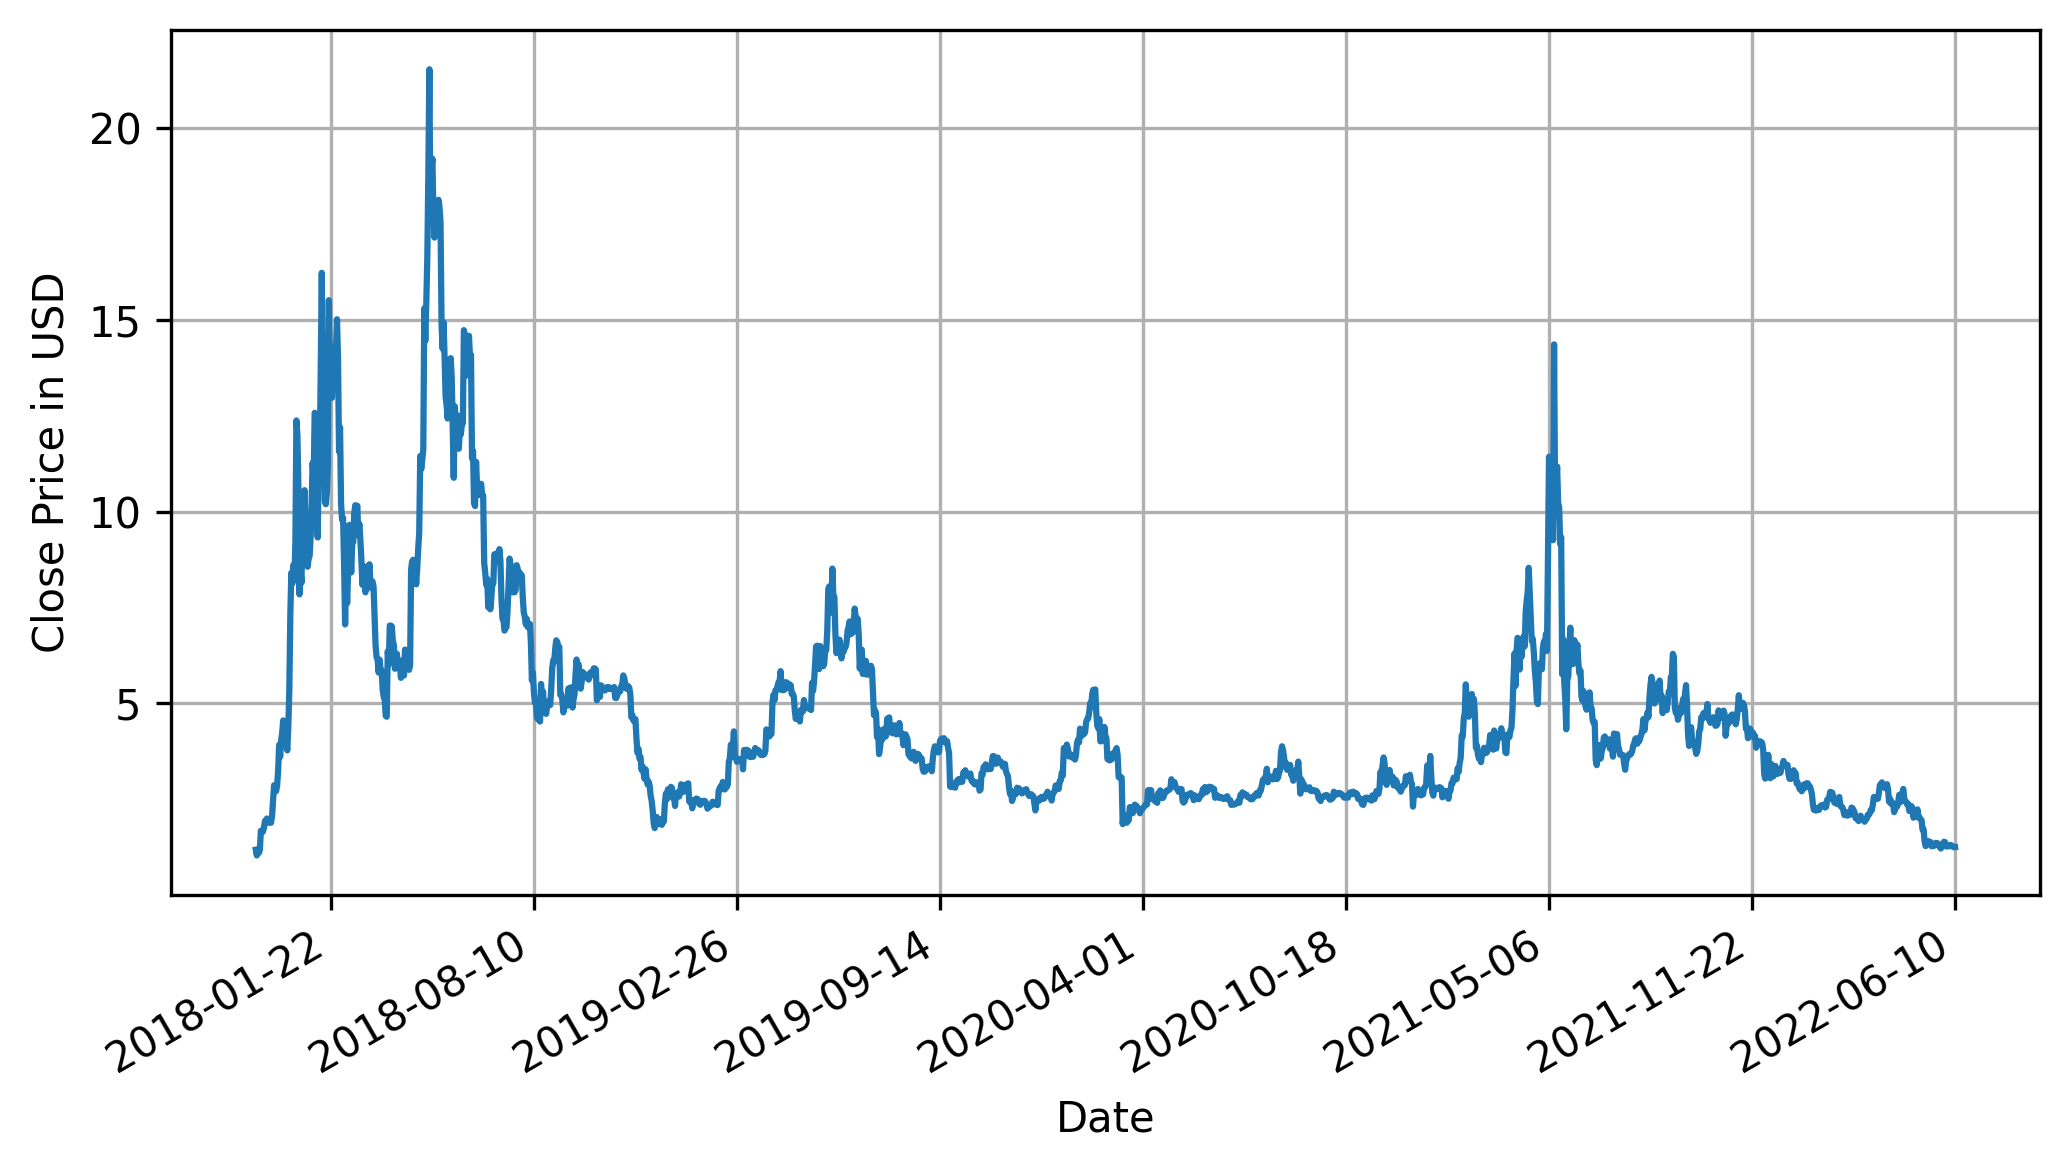

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1475 200
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               252000    
                                   

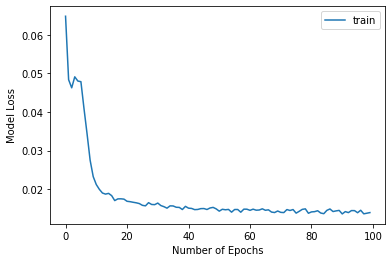

6/6 [==============================] - 0s 6ms/step


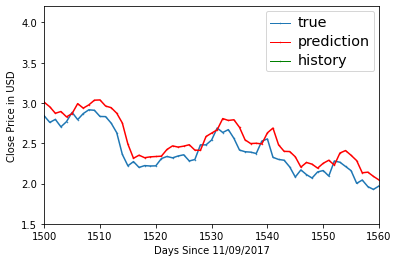

(190,)
(190, 1)
Root mean squared error: 0.18473039057364693
mappingproxy({'__dict__': <attribute '__dict__' of 'StopWatch' objects>,
              '__doc__': '\n    A class to measure times between events.\n    ',
              '__module__': 'cloudmesh.common.StopWatch',
              '__str__': <classmethod(<function StopWatch.__str__ at 0x0000024EBF7497E0>)>,
              '__weakref__': <attribute '__weakref__' of 'StopWatch' objects>,
              'activate_mllog': <classmethod(<function StopWatch.activate_mllog at 0x0000024EBF748F70>)>,
              'benchmark': <classmethod(<function StopWatch.benchmark at 0x0000024EBF749A20>)>,
              'clear': <classmethod(<function StopWatch.clear at 0x0000024EBF749630>)>,
              'debug': False,
              'event': <classmethod(<function StopWatch.event at 0x0000024EBF7492D0>)>,
              'get': <classmethod(<function StopWatch.get at 0x0000024EBF749510>)>,
              'get_benchmark': <classmethod(<function StopWatch.

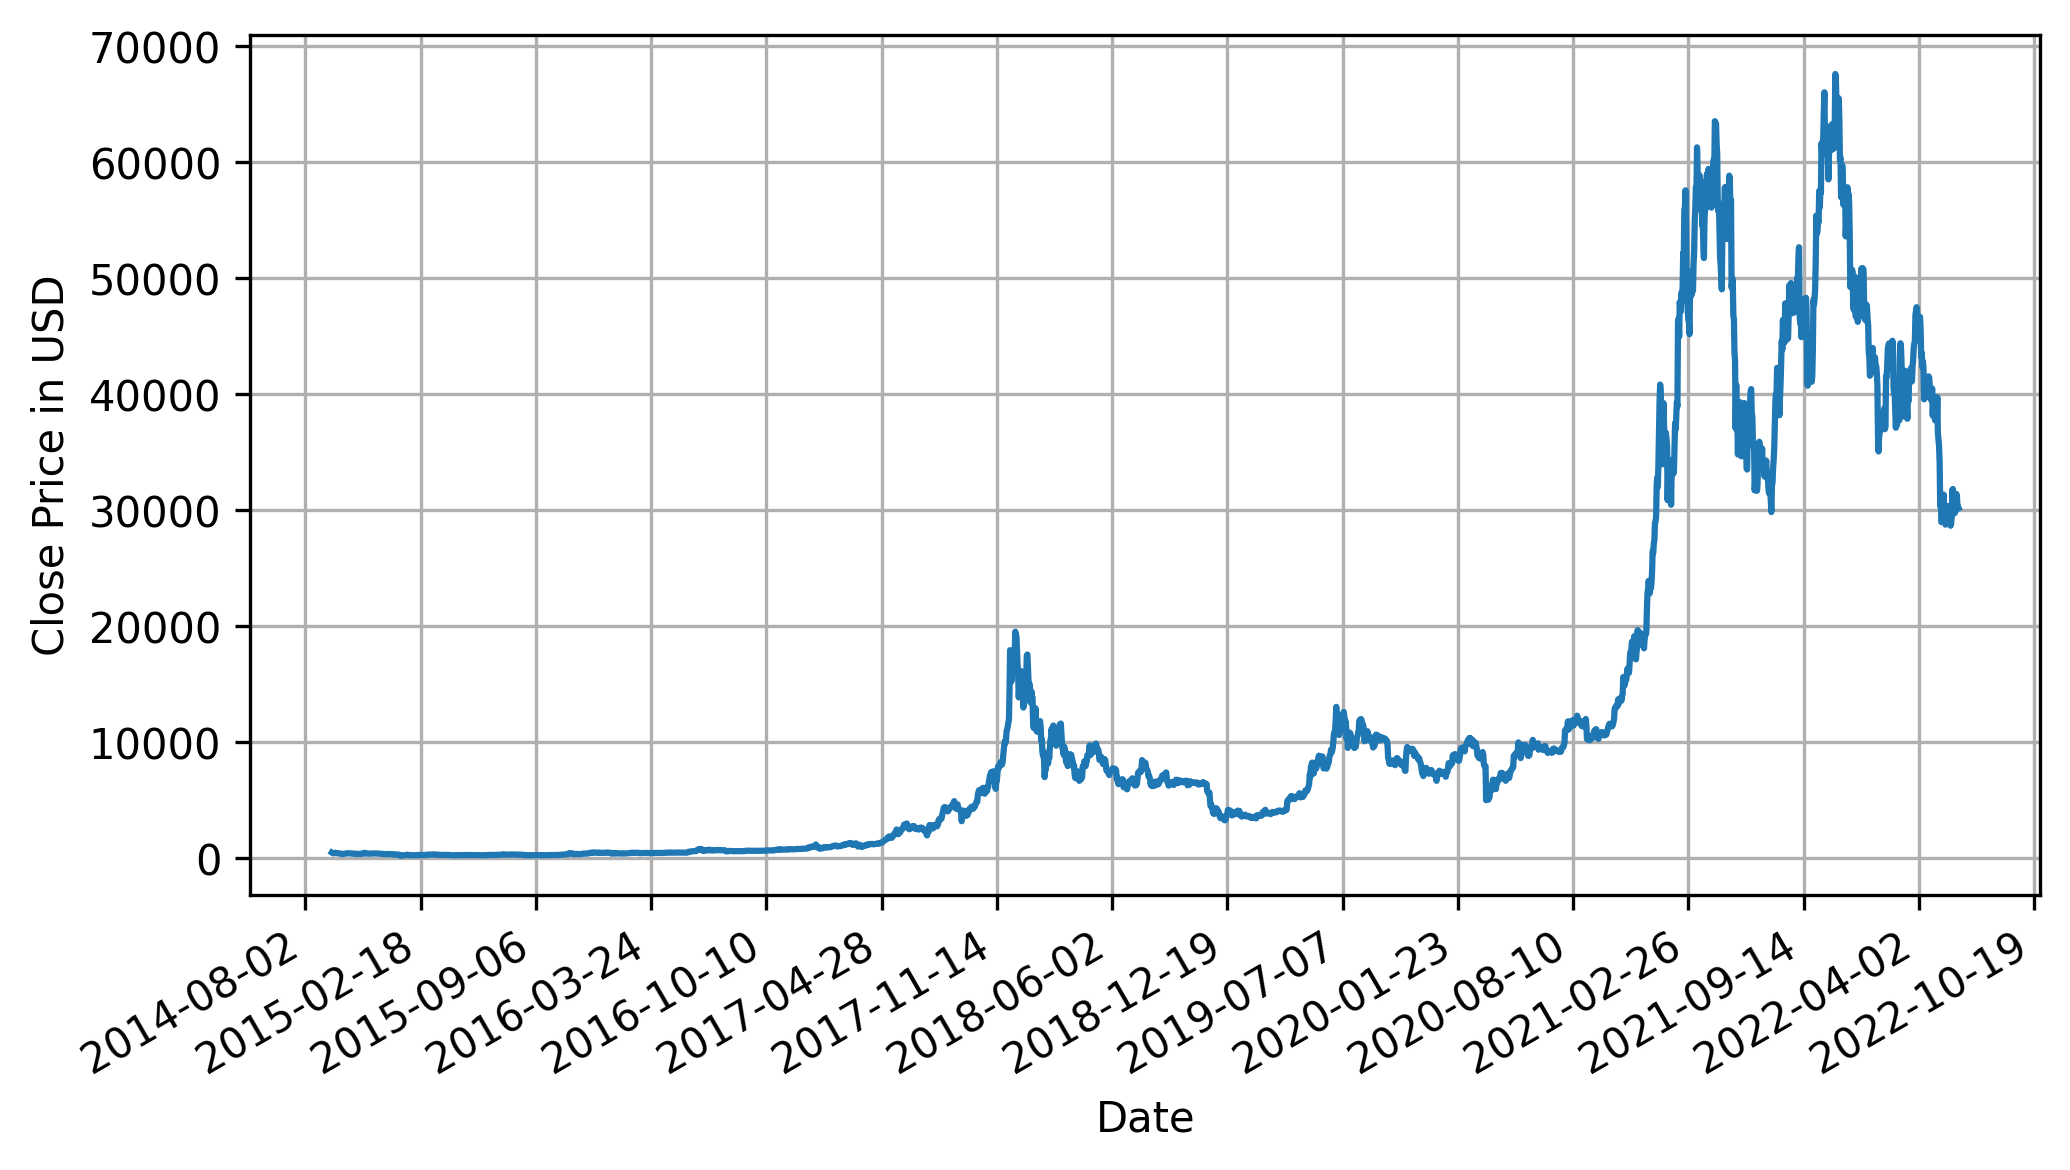

2014-09-17 00:00:00
2014-09-17 00:00:00
09/17/2014
                  Open        High         Low       Close    Volume  \
Date                                                                   
2014-09-17  465.864014  468.174011  452.421997  457.334015  21056800   
2014-09-18  456.859985  456.859985  413.104004  424.440002  34483200   
2014-09-19  424.102997  427.834991  384.532013  394.795990  37919700   
2014-09-20  394.673004  423.295990  389.882996  408.903992  36863600   
2014-09-21  408.084991  412.425995  393.181000  398.821014  26580100   

            Dividends  Stock Splits  
Date                                 
2014-09-17          0             0  
2014-09-18          0             0  
2014-09-19          0             0  
2014-09-20          0             0  
2014-09-21          0             0  
2624 200
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM) 

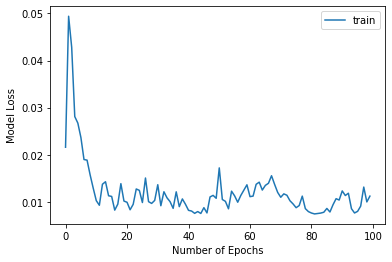

6/6 [==============================] - 0s 5ms/step


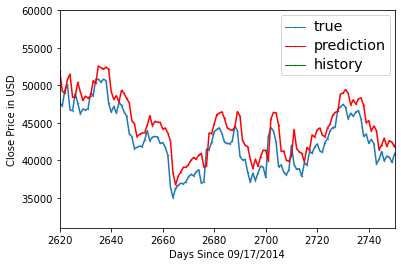

(190,)
(190, 1)
Root mean squared error: 2489.585713218961
mappingproxy({'__dict__': <attribute '__dict__' of 'StopWatch' objects>,
              '__doc__': '\n    A class to measure times between events.\n    ',
              '__module__': 'cloudmesh.common.StopWatch',
              '__str__': <classmethod(<function StopWatch.__str__ at 0x0000024EBF7497E0>)>,
              '__weakref__': <attribute '__weakref__' of 'StopWatch' objects>,
              'activate_mllog': <classmethod(<function StopWatch.activate_mllog at 0x0000024EBF748F70>)>,
              'benchmark': <classmethod(<function StopWatch.benchmark at 0x0000024EBF749A20>)>,
              'clear': <classmethod(<function StopWatch.clear at 0x0000024EBF749630>)>,
              'debug': False,
              'event': <classmethod(<function StopWatch.event at 0x0000024EBF7492D0>)>,
              'get': <classmethod(<function StopWatch.get at 0x0000024EBF749510>)>,
              'get_benchmark': <classmethod(<function StopWatch.ge

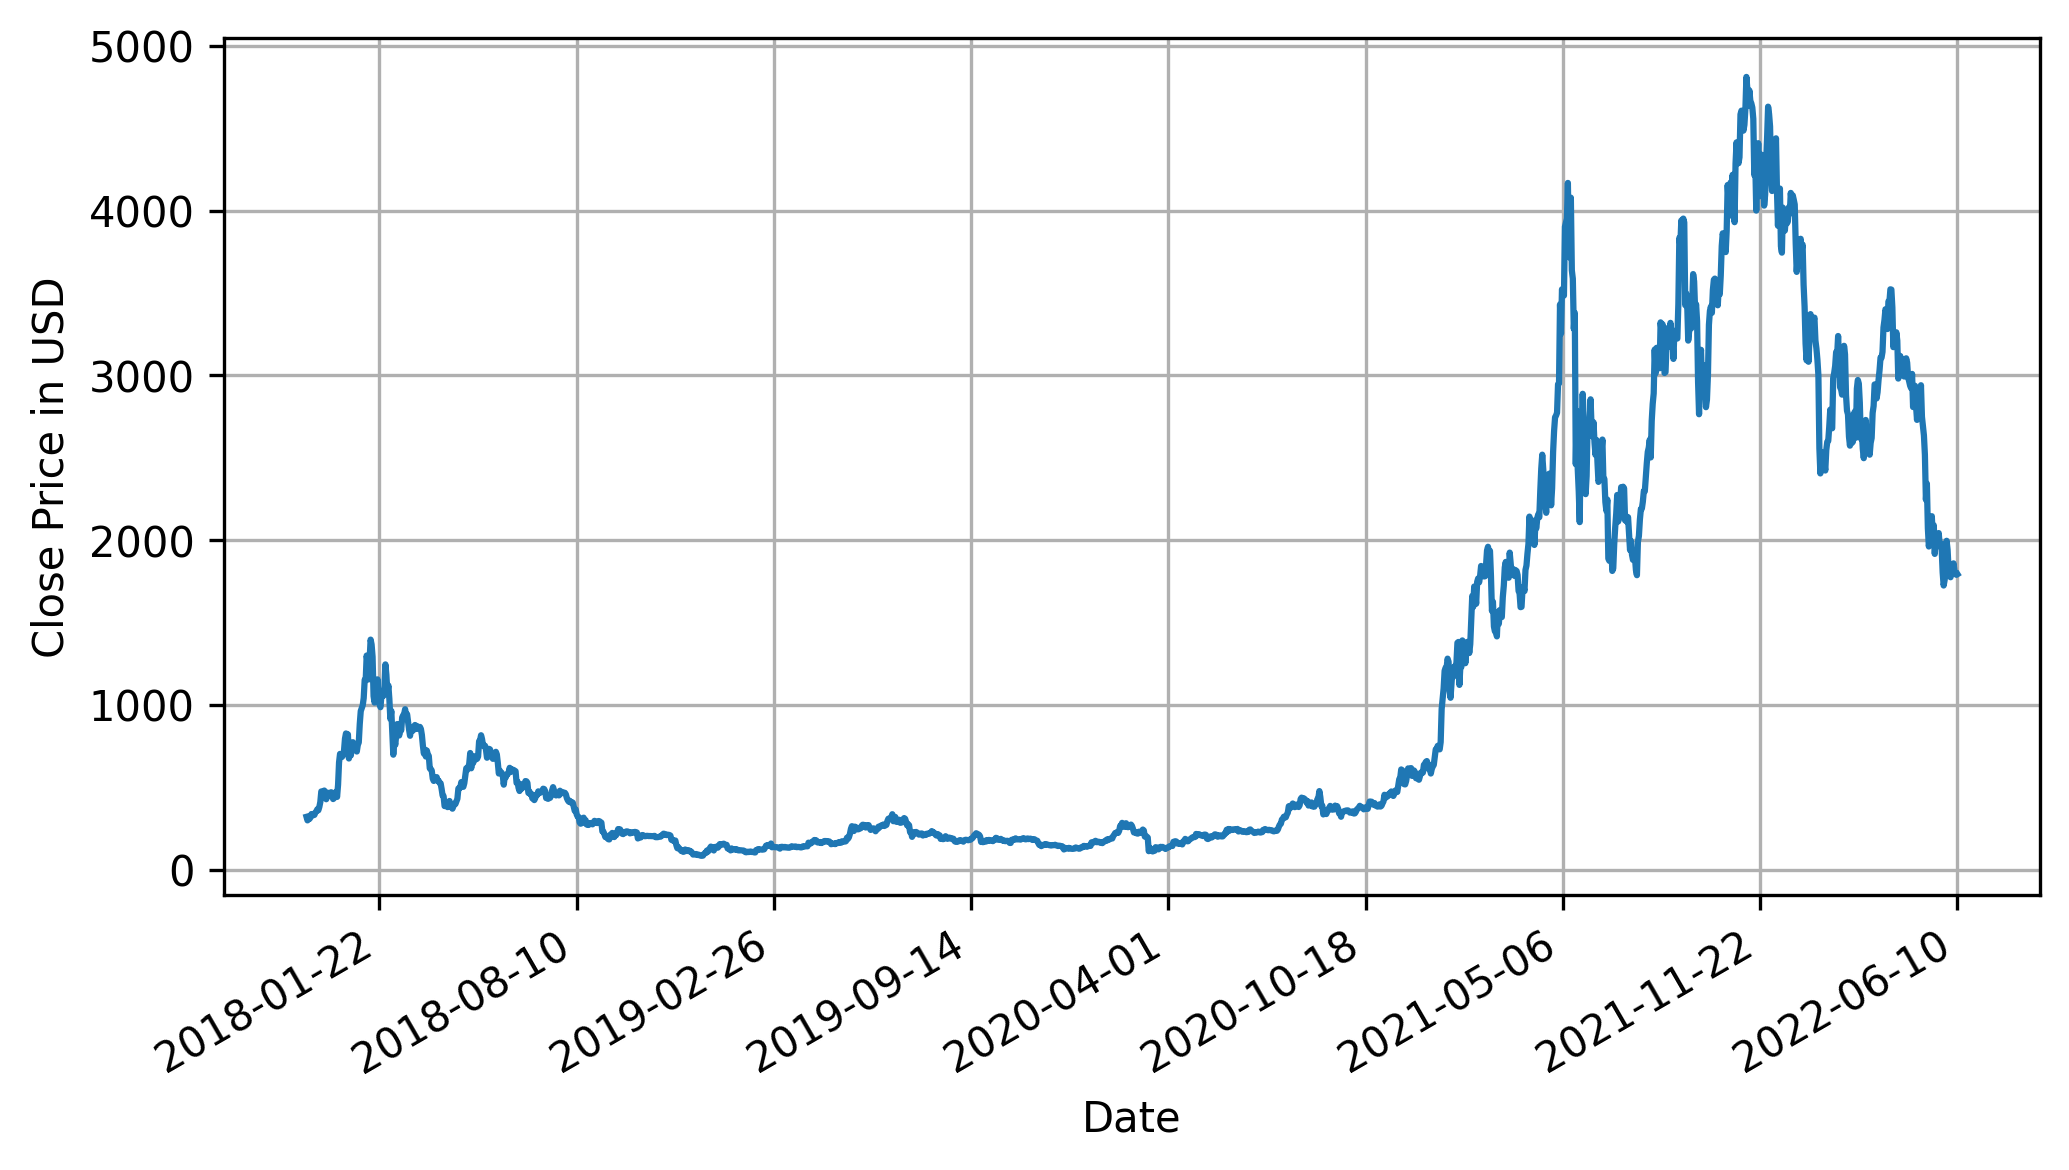

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                  Open        High         Low       Close      Volume  \
Date                                                                     
2017-11-09  308.644989  329.451996  307.056000  320.884003   893249984   
2017-11-10  320.670990  324.717987  294.541992  299.252991   885985984   
2017-11-11  298.585999  319.453003  298.191986  314.681000   842300992   
2017-11-12  314.690002  319.153015  298.513000  307.907990  1613479936   
2017-11-13  307.024994  328.415009  307.024994  316.716003  1041889984   

            Dividends  Stock Splits  
Date                                 
2017-11-09          0             0  
2017-11-10          0             0  
2017-11-11          0             0  
2017-11-12          0             0  
2017-11-13          0             0  
1475 200
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 

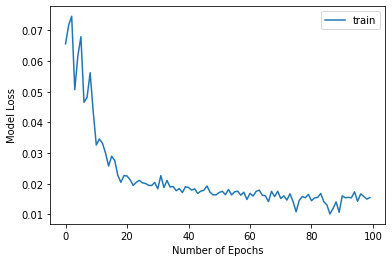

6/6 [==============================] - 0s 6ms/step


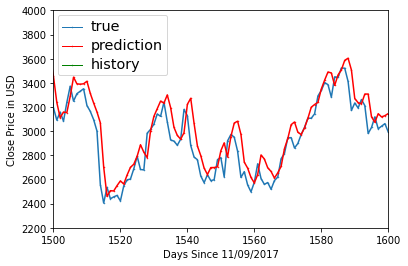

(190,)
(190, 1)
Root mean squared error: 151.1034678311674
mappingproxy({'__dict__': <attribute '__dict__' of 'StopWatch' objects>,
              '__doc__': '\n    A class to measure times between events.\n    ',
              '__module__': 'cloudmesh.common.StopWatch',
              '__str__': <classmethod(<function StopWatch.__str__ at 0x0000024EBF7497E0>)>,
              '__weakref__': <attribute '__weakref__' of 'StopWatch' objects>,
              'activate_mllog': <classmethod(<function StopWatch.activate_mllog at 0x0000024EBF748F70>)>,
              'benchmark': <classmethod(<function StopWatch.benchmark at 0x0000024EBF749A20>)>,
              'clear': <classmethod(<function StopWatch.clear at 0x0000024EBF749630>)>,
              'debug': False,
              'event': <classmethod(<function StopWatch.event at 0x0000024EBF7492D0>)>,
              'get': <classmethod(<function StopWatch.get at 0x0000024EBF749510>)>,
              'get_benchmark': <classmethod(<function StopWatch.ge

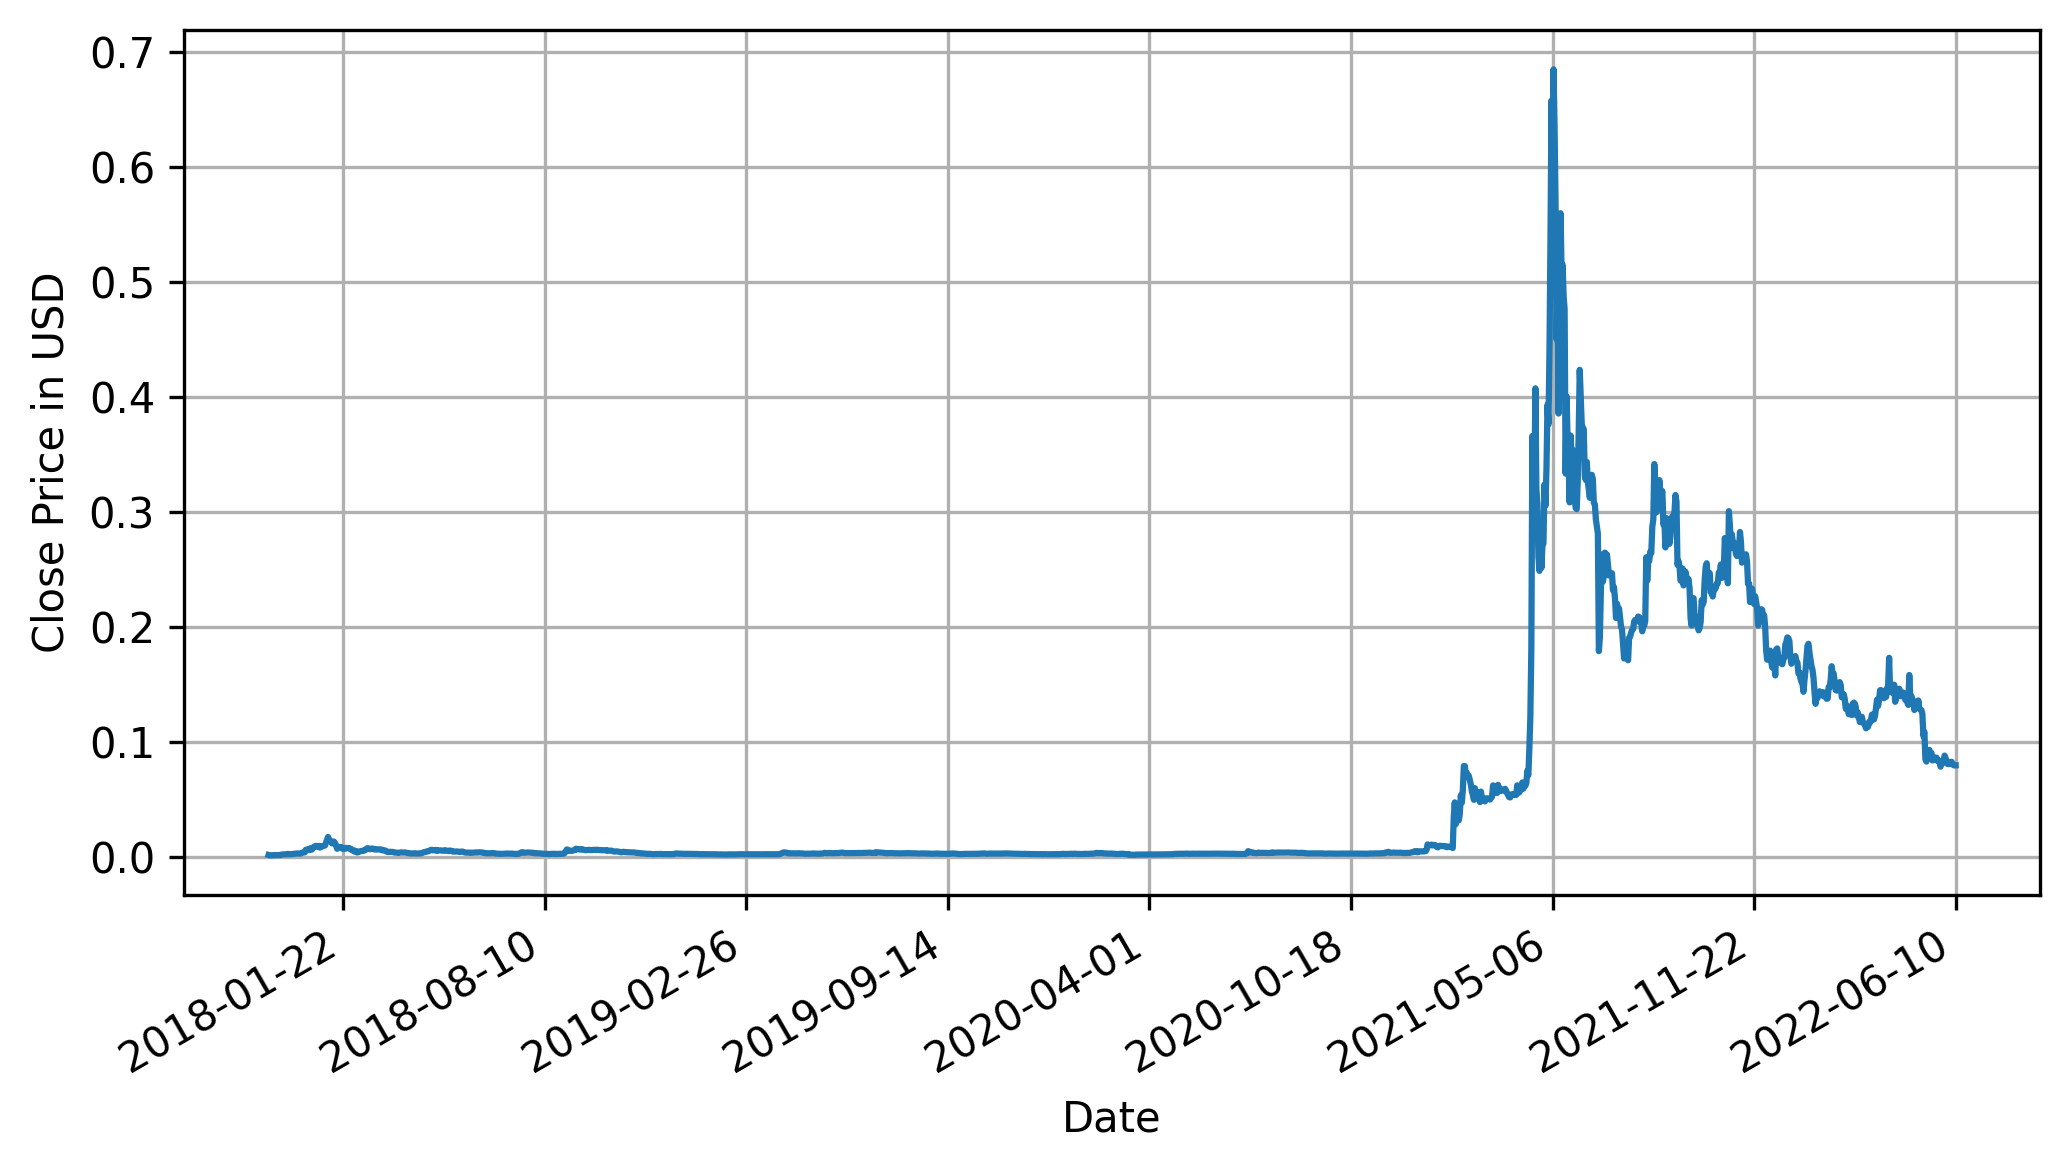

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
                Open      High       Low     Close   Volume  Dividends  \
Date                                                                     
2017-11-09  0.001207  0.001415  0.001181  0.001415  6259550          0   
2017-11-10  0.001421  0.001431  0.001125  0.001163  4246520          0   
2017-11-11  0.001146  0.001257  0.001141  0.001201  2231080          0   
2017-11-12  0.001189  0.001210  0.001002  0.001038  3288960          0   
2017-11-13  0.001046  0.001212  0.001019  0.001211  2481270          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1475 200
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 250)               252000    
            

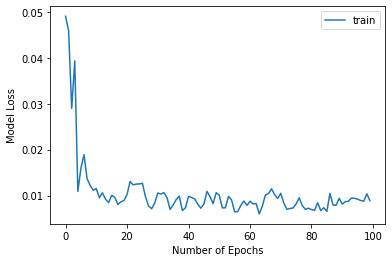

6/6 [==============================] - 0s 6ms/step


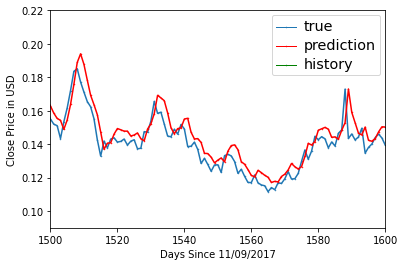

(190,)
(190, 1)
Root mean squared error: 0.00887180744052602
mappingproxy({'__dict__': <attribute '__dict__' of 'StopWatch' objects>,
              '__doc__': '\n    A class to measure times between events.\n    ',
              '__module__': 'cloudmesh.common.StopWatch',
              '__str__': <classmethod(<function StopWatch.__str__ at 0x0000024EBF7497E0>)>,
              '__weakref__': <attribute '__weakref__' of 'StopWatch' objects>,
              'activate_mllog': <classmethod(<function StopWatch.activate_mllog at 0x0000024EBF748F70>)>,
              'benchmark': <classmethod(<function StopWatch.benchmark at 0x0000024EBF749A20>)>,
              'clear': <classmethod(<function StopWatch.clear at 0x0000024EBF749630>)>,
              'debug': False,
              'event': <classmethod(<function StopWatch.event at 0x0000024EBF7492D0>)>,
              'get': <classmethod(<function StopWatch.get at 0x0000024EBF749510>)>,
              'get_benchmark': <classmethod(<function StopWatch.

In [4]:
list_of_cryptos = ["EOS-USD", "BTC-USD", "ETH-USD", "DOGE-USD"]
for crypto in list_of_cryptos:
    lstm(crypto)